In [ ]:
from tqdm.autonotebook import tqdm
import os
import numpy as np
import pacmap
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import tensorflow as tf
from sklearn.utils import shuffle
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
import sentencepiece as spm
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score


from tensorflow.keras.utils import plot_model
import subprocess
import sys
import time
from termcolor import colored, cprint
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tqdm import tqdm
import pacmap

In [2]:
TEST="Test Program"
MAX_SIZE=150 # Largest input size in character length
print(TEST + " " + str(MAX_SIZE))

Test Program 150


In [3]:
def calcF1(actual, pred):
    predP = []
    for x in pred:
        if x > 0.5:
            predP.append(1)
        else:
            predP.append(0)
            
    return f1_score(actual, predP)


In [4]:
# Convert ASCII values into numerical
# Shift by +1 to allow 0 padding
# Used for later testing/demonstrations
def encodeVals(inStr):
    vals = np.array([ord(x) + 1 for x in inStr])
    l = len(vals)
    if l > MAX_SIZE:
        print(inStr)
    pad = np.zeros(MAX_SIZE - l, dtype="int")
    vals = np.append(vals, pad)

    return np.array(vals)

In [8]:
# Read all input samples from a directory
# Assumes they are the only file type present
# Pads to MAX_SIZE and encodes
def loadValues(d):
    xs = []
    for filename in tqdm(os.listdir(d)):
        with open(d + filename, 'rb') as f:
            inStr = f.read()
            vals = np.array([x + 1 for x in inStr])
            l = len(vals)
            if l > MAX_SIZE:
                continue
                
            pad = np.zeros(MAX_SIZE - l, dtype="int")
            vals = np.append(vals, pad)
            xs.append(vals)
    return np.array(xs)

In [10]:
# Simple plot of receiver-operator-characteristics and area under the curve
def rocAuc(trials, names=["Dense", "Transformer"], colors=["Blue", "Orange"], leadIn="", figName=None):
    plt.figure(figsize=(10, 8), dpi=100)
    plt.axis('scaled')
    plt.xlim(-0.01, 1)
    plt.ylim(0, 1.01)
    plt.title(leadIn + "ROC Curve & AUC/F1 Scores")
    plt.plot([0,1],[0,1],'--', color='darkgray')

    stringBuilder = ""
    scoreBuilder = []
    for (i, (model, x_test, y_test)) in enumerate(trials):
        y_pred = model.predict(x_test)
        auc = metrics.roc_auc_score(y_test, y_pred)

        false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_test, y_pred)
        f1 = calcF1(y_test, y_pred)

        plt.plot(false_positive_rate, true_positive_rate, colors[i])
        plt.fill_between(false_positive_rate, true_positive_rate, facecolor=colors[i], alpha=0.1)
        stringBuilder += names[i] + " F1 = %0.4f\nAUC = %0.4f\n\n"
        scoreBuilder.append(f1)
        scoreBuilder.append(auc)
    plt.text(0.95, 0.05, stringBuilder[:-1] % tuple(scoreBuilder), ha='right', fontsize=12, color='black')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    hdls = [mpatches.Patch(color=colors[i], label=names[i]) for i in range(len(names))]
    plt.legend(handles=hdls, loc='center right')
    if figName is not None:
        plt.savefig(figName, bbox_inches='tight')

    plt.show()
    


In [11]:
# PaCMAP Visualization
def plotPac(corpus, yt, maxNum=-1, colors = ['blue', 'orange'], names=['Nominal','Crash'], sz=1.5, alpha=0.5):
    if maxNum < 0:
        maxNum = len(corpus)
    embedding = pacmap.PaCMAP(n_dims=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    xt = embedding.fit_transform(corpus[:maxNum], init="pca")
    cmap = mpl.colors.ListedColormap(colors)
    sns.set_style('darkgrid')

    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(xt[:, 0], xt[:, 1], cmap=cmap, c=yt[:maxNum], s=sz, alpha=alpha)

    hdls = [mpatches.Patch(color=colors[i], label=names[i]) for i in range(len(names))]
    ax.legend(handles=hdls)

In [13]:
CRASH_DIR="./testProgram_crash500k/"
NOMINAL_DIR="./testProgram_nominal500k/"

In [14]:
allCrash = loadValues(CRASH_DIR)
allNominal = loadValues(NOMINAL_DIR)

100%|██████████| 551503/551503 [01:06<00:00, 8267.10it/s] 


In [15]:
# Capture original lens
lenCrash0 = len(allCrash)
lenNominal0 = len(allNominal)

# Uniques only
allCrash = np.unique(allCrash, axis=0)
allNominal = np.unique(allNominal, axis=0)

# Show results
print(f"Crash set was {lenCrash0}, now {len(allCrash)}.")
print(f"Nominal set was {lenNominal0}, now {len(allNominal)}.")

Crash set was 535972, now 501456.
Nominal set was 551503, now 449413.


In [16]:
# Create training corpus with labels
corpus = np.vstack([allNominal, allCrash])
labels = np.array([0]*len(allNominal) + [1]*len(allCrash))
print(f"Corpus: {corpus.shape}, Labels: {labels.shape}")

Corpus: (950869, 150), Labels: (950869,)


In [17]:
# Shuffle to ensure mixed for pacmap
corpus, labels = shuffle(corpus, labels)

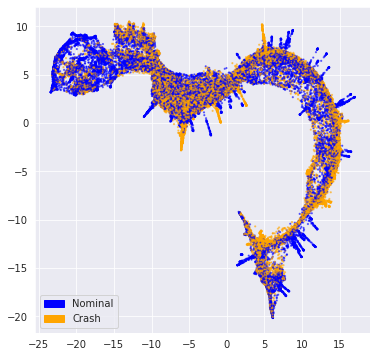

In [18]:
plotPac(corpus, labels, maxNum=50000)

In [19]:
x_train, y_train = shuffle(corpus, labels)
testSplit = int(0.2*len(x_train))

In [20]:
# Simple dense layer model for comparison
inputs = layers.Input(shape=(MAX_SIZE,))
x = layers.Dense(85, activation="relu", name="dense1")(inputs) # 85
x = layers.Dropout(0.2)(x)
x = layers.Dense(200, activation="relu", name="dense2")(x) #100
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)
modelDense = keras.Model(inputs=inputs, outputs=outputs)
modelDense.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
modelDense.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
dense1 (Dense)               (None, 85)                12835     
_________________________________________________________________
dropout (Dropout)            (None, 85)                0         
_________________________________________________________________
dense2 (Dense)               (None, 200)               17200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 30,236
Trainable params: 30,236
Non-trainable params: 0
_________________________________________________________

In [22]:
MODEL_FILE="mdl.hdf5"
modelSave = ModelCheckpoint(MODEL_FILE, save_best_only=True, monitor='val_loss', mode='min')

In [23]:
history = modelDense.fit(x_train[:-testSplit], y_train[:-testSplit],
      batch_size=512,
      epochs=50,
      validation_split=0.15,
      verbose=1,
      callbacks=[modelSave])

Epoch 1/50
1263/1263 [==============================] - 2s 1ms/step - loss: 0.3958 - accuracy: 0.5970 - val_loss: 0.3442 - val_accuracy: 0.6296
Epoch 2/50
1263/1263 [==============================] - 1s 905us/step - loss: 0.2600 - accuracy: 0.6182 - val_loss: 0.2140 - val_accuracy: 0.6514
Epoch 3/50
1263/1263 [==============================] - 1s 905us/step - loss: 0.2143 - accuracy: 0.6526 - val_loss: 0.2048 - val_accuracy: 0.6733
Epoch 4/50
1263/1263 [==============================] - 1s 894us/step - loss: 0.2083 - accuracy: 0.6630 - val_loss: 0.1987 - val_accuracy: 0.6841
Epoch 5/50
1263/1263 [==============================] - 1s 895us/step - loss: 0.2049 - accuracy: 0.6695 - val_loss: 0.1956 - val_accuracy: 0.6918
Epoch 6/50
1263/1263 [==============================] - 1s 902us/step - loss: 0.2015 - accuracy: 0.6765 - val_loss: 0.1955 - val_accuracy: 0.6893
Epoch 7/50
1263/1263 [==============================] - 1s 914us/step - loss: 0.1991 - accuracy: 0.6804 - val_loss: 0.1902 - v

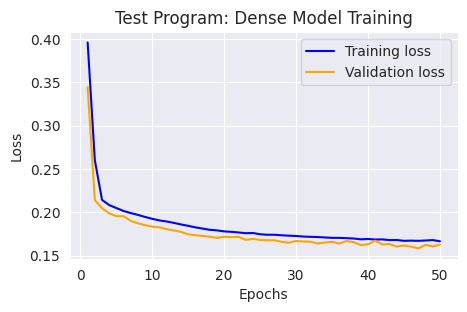

In [24]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.figure(figsize=(5, 3), dpi=100)

sns.set_style('darkgrid')

plt.plot(epochs, loss_values, "b", label="Training loss")
plt.plot(epochs, val_loss_values, "orange", label="Validation loss")
plt.title("Test Program: Dense Model Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [25]:
max_length = MAX_SIZE
max_tokens = MAX_SIZE


In [26]:
# Transformer architecture
# Largely taken from: https://keras.io/examples/nlp/text_classification_with_transformer/
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [27]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [28]:
# Run a prediction and pacmap the output
def vizLayer(m, x_test, y_test):
  viz = m.predict(x_test)
  vizp = np.reshape(viz, (viz.shape[0],viz.shape[1]*viz.shape[2]))
  vp, lp = shuffle(vizp, y_test)
  plotPac(vp, lp)

In [29]:
# Putting together the full model
embed_dim = 32 # Embedding size for each token
num_heads = 8 # Number of attention heads
ff_dim = 32 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, max_tokens, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [30]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
token_and_position_embedding (None, 150, 32)           9600      
_________________________________________________________________
transformer_block (Transform (None, 150, 32)           35808     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)                0   

In [31]:
print(model.layers[1].name)
print(model.layers[2].name)

token_and_position_embedding
transformer_block


In [32]:
embedOnly_model = keras.Model(model.inputs,[model.layers[1].output])
transformerOnly_model = keras.Model(model.inputs, model.layers[2].output)
transformerOnly_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
token_and_position_embedding (None, 150, 32)           9600      
_________________________________________________________________
transformer_block (Transform (None, 150, 32)           35808     
Total params: 45,408
Trainable params: 45,408
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

In [34]:
history = model.fit(x_train[:-testSplit], y_train[:-testSplit],
          batch_size=512,
          epochs=10,
          validation_split=0.15)

Epoch 1/10
1263/1263 [==============================] - 35s 27ms/step - loss: 0.0705 - accuracy: 0.9080 - val_loss: 0.0311 - val_accuracy: 0.9605
Epoch 2/10
1263/1263 [==============================] - 34s 27ms/step - loss: 0.0247 - accuracy: 0.9690 - val_loss: 0.0220 - val_accuracy: 0.9720
Epoch 3/10
1263/1263 [==============================] - 34s 27ms/step - loss: 0.0195 - accuracy: 0.9756 - val_loss: 0.0178 - val_accuracy: 0.9775
Epoch 4/10
1263/1263 [==============================] - 34s 27ms/step - loss: 0.0147 - accuracy: 0.9815 - val_loss: 0.0120 - val_accuracy: 0.9849
Epoch 5/10
1263/1263 [==============================] - 34s 27ms/step - loss: 0.0114 - accuracy: 0.9856 - val_loss: 0.0106 - val_accuracy: 0.9866
Epoch 6/10
1263/1263 [==============================] - 34s 27ms/step - loss: 0.0100 - accuracy: 0.9874 - val_loss: 0.0095 - val_accuracy: 0.9880
Epoch 7/10
1263/1263 [==============================] - 34s 27ms/step - loss: 0.0090 - accuracy: 0.9885 - val_loss: 0.0088 -

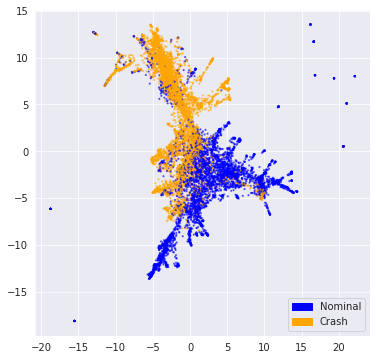

In [35]:
vizLayer(embedOnly_model, x_train[-10000:], y_train[-10000:])

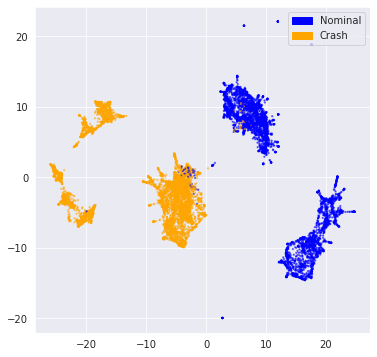

In [36]:
vizLayer(transformerOnly_model, x_train[-10000:], y_train[-10000:])

In [41]:
# Reduced architecture to remove multi-head attention
# Supports ablative studies to see when benefits from embed/position
inputs = layers.Input(shape=(max_length,))
embedding_layer = TokenAndPositionEmbedding(max_length, max_tokens, embed_dim)
x = embedding_layer(inputs)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

modelAbl = keras.Model(inputs=inputs, outputs=outputs)

In [42]:
modelAbl.compile(optimizer="adam", loss="mse", metrics=["accuracy"])


In [39]:
history = modelAbl.fit(x_train[:-testSplit], y_train[:-testSplit],
          batch_size=512,
          epochs=20,
          validation_split=0.15)

Epoch 1/20
1263/1263 [==============================] - 2s 2ms/step - loss: 0.1191 - accuracy: 0.8448 - val_loss: 0.0830 - val_accuracy: 0.8985
Epoch 2/20
1263/1263 [==============================] - 2s 1ms/step - loss: 0.0810 - accuracy: 0.9003 - val_loss: 0.0758 - val_accuracy: 0.9056
Epoch 3/20
1263/1263 [==============================] - 2s 1ms/step - loss: 0.0760 - accuracy: 0.9074 - val_loss: 0.0724 - val_accuracy: 0.9126
Epoch 4/20
1263/1263 [==============================] - 2s 1ms/step - loss: 0.0724 - accuracy: 0.9122 - val_loss: 0.0707 - val_accuracy: 0.9162
Epoch 5/20
1263/1263 [==============================] - 2s 1ms/step - loss: 0.0668 - accuracy: 0.9203 - val_loss: 0.0592 - val_accuracy: 0.9285
Epoch 6/20
1263/1263 [==============================] - 2s 1ms/step - loss: 0.0561 - accuracy: 0.9332 - val_loss: 0.0465 - val_accuracy: 0.9424
Epoch 7/20
1263/1263 [==============================] - 2s 1ms/step - loss: 0.0456 - accuracy: 0.9450 - val_loss: 0.0387 - val_accuracy:

In [44]:
def getReturn(x):
    vals = []
    for z in x:
        if z == 0:
            break
        vals.append(chr(int(z-1)))

    inp = "".join(vals)
    #print(inp)
    return run( [ '/home/g/afl/secondToy/stateTester'], input=inp.encode() ).returncode

In [45]:
def revVals(x):
    vals = []
    for z in x:
        if z == 0:
            break
        vals.append(chr(int(z-1)))

    inp = "".join(vals)
    return inp

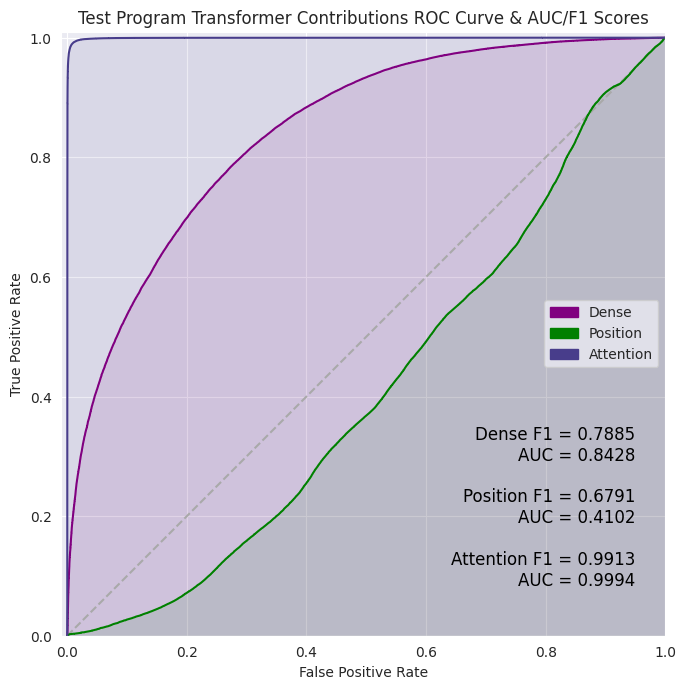

In [46]:
x_test = x_train[-testSplit:]
y_test = y_train[-testSplit:]
rocAuc( [ (modelDense, x_test, y_test)
        , (modelAbl, x_test, y_test)
        , (model, x_test, y_test)
        ]
        , names = ["Dense", "Position", "Attention"]
        , colors = ['purple', 'green', 'darkslateblue']
        , leadIn= TEST + " Transformer Contributions ", figName= TEST + "scores")

# Demonstration

In [47]:
model(np.array([encodeVals("<?xml versionencoding=\"es�(base) ")]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.9999958]], dtype=float32)>

In [48]:
def decodeVals(inVals):
    r = ""
    for x in inVals:
        if x == 0:
            break
        r += chr(int(x) - 1)
    return r

In [49]:
# Timings
def timeInput(inp):
    st = time.time()
    v = encodeVals(inp)
    t = model(np.array([v]))
    b = False
    if t.numpy()[0][0] >= 0.5:
        b = True
    et = time.time()
    elapsed_time = et - st
    return elapsed_time


In [ ]:
timeInput(decodeVals(x_test[0]))
acc = 0
for x in tqdm(x_test):
    acc += timeInput(decodeVals(x))
print("Avg time: " + str(1000*acc/len(x_test)))

In [ ]:
timeInput(decodeVals(x_test[0]))
acc = 0
for x in tqdm(x_test):
    acc += timeInput(decodeVals(x))
print("Avg time: " + str(1000*acc/len(x_test)))

In [ ]:
x_test_vals = modelDense(x_test)

In [ ]:
predP = []
for x in x_test_vals:
    if x > 0.5:
        predP.append(1)
    else:
        predP.append(0)

In [ ]:
c = 0
for (i, (p, t)) in enumerate(zip(predP, y_test)):
    if p != t:
        c += 1
print(c)
print(len(y_test))


In [ ]:

p = subprocess.Popen('echo "<sta>tsadf</t>" | ~/afl/secondToy/testProgram', shell=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
lines = p.stdout.readlines()
print(lines)


In [ ]:
from sklearn import metrics
auc = metrics.roc_auc_score(y_train[-testSplit:], y_pred)
aucD = metrics.roc_auc_score(y_trueDense, y_predDense)

false_positive_rate, true_positive_rate, thresolds = metrics.roc_curve(y_train[-testSplit:], y_pred)
false_positive_rateD, true_positive_rateD, thresoldsD = metrics.roc_curve(y_trueDense, y_predDense)

plt.figure(figsize=(10, 8), dpi=100)
plt.axis('scaled')
plt.xlim([0, 1])
plt.ylim([0, 1])
#plt.title("AUC & ROC Curve")

plt.plot([0,1],[0,1],'--')
plt.plot(false_positive_rate, true_positive_rate, 'b')
plt.plot(false_positive_rateD, true_positive_rateD, 'orange')

plt.fill_between(false_positive_rate, true_positive_rate, facecolor='blue', alpha=0.1)
plt.fill_between(false_positive_rateD, true_positive_rateD, facecolor='orange', alpha=0.1)

plt.text(0.95, 0.05, 'Dense AUC = %0.4f\nTransformer AUC = %0.4f' % (aucD, auc), ha='right', fontsize=12, weight='bold', color='blue')
plt.xlim(-0.01,1)
plt.ylim(0,1.01)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()